Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
#loading and preparing the dataset
df = pd.read_csv("/Users/Khaja/group-coursework-k-means-of-chaos/data/arabica_ratings_raw.csv")

In [10]:
features = ['Aroma','Flavor','Aftertaste','Acidity','Body','Balance','Uniformity','Clean Cup','Sweetness','Cupper Points']
target = 'quality_score'

In [11]:
df = df.dropna(subset = features + [target])
print (f"Loaded Dataset: {df.shape[0]} samples")

Loaded Dataset: 1312 samples


#Standardising the data

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

In [13]:
#importing libraries for clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [14]:
# clustering for feature evaluation
kmeans = KMeans(n_clusters=3, random_state = 42, n_init = 20)
df['cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\Khaja\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Khaja\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Khaja\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Khaja\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

In [16]:
#Cluster Quality Metrics
s_score = silhouette_score(X_scaled, df['cluster'])
db_score = davies_bouldin_score(X_scaled, df['cluster'])
print(f"\nCluster Quality:")
print(f"Silhouette Score     : {s_score:.3f}")
print(f"Davies–Bouldin Index : {db_score:.3f}")


Cluster Quality:
Silhouette Score     : 0.324
Davies–Bouldin Index : 0.828


In [17]:
#dimensionality reduction and visualisation 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

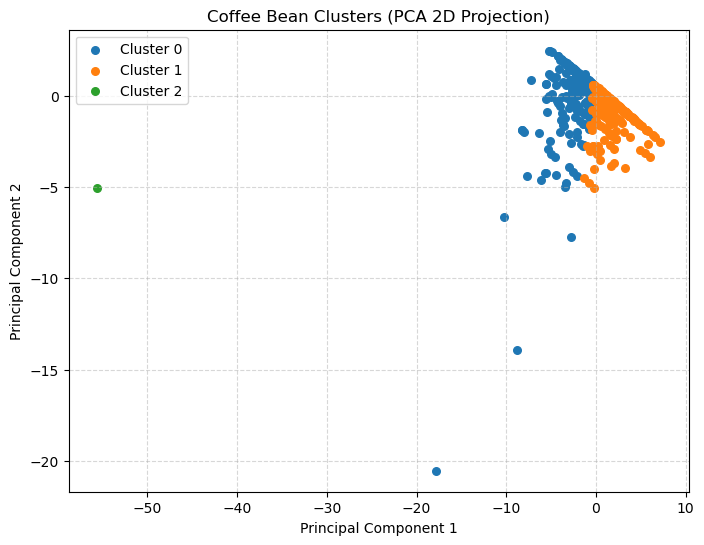

In [19]:
plt.figure(figsize=(8,6))
for c in np.unique(df['cluster']):
    plt.scatter(X_pca[df['cluster']==c, 0],
                X_pca[df['cluster']==c, 1],
                label=f"Cluster {c}", s=30)
plt.title("Coffee Bean Clusters (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [21]:
#inter-cluster Variance
feature_variance = df.groupby('cluster')[features].mean().var().sort_values(ascending=False)
print("\nFeature variance across clusters:")
display(feature_variance)


Feature variance across clusters:


Sweetness        32.601797
Uniformity       32.058572
Clean Cup        31.990021
Aroma            18.865213
Acidity          18.704925
Body             18.643706
Balance          18.591432
Flavor           18.588857
Cupper Points    18.459999
Aftertaste       17.991616
dtype: float64

In [22]:
top_features = feature_variance.head(5).index.tolist()
print(f"Top discriminative features: {top_features}")

Top discriminative features: ['Sweetness', 'Uniformity', 'Clean Cup', 'Aroma', 'Acidity']


In [23]:
#Hierarchial Clustering of Features
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import combinations

In [24]:
corr = df[features].corr().abs()
Z = linkage(1 - corr, method='average')

C:\Users\Khaja\AppData\Local\Temp\ipykernel_15564\1660962624.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - corr, method='average')


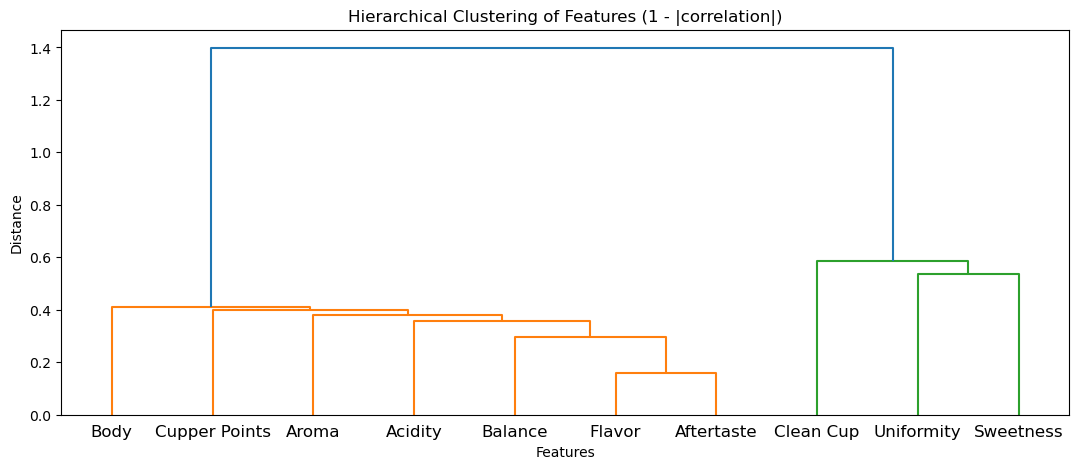

In [27]:
plt.figure(figsize=(13,5))
dendrogram(Z, labels=features)
plt.title("Hierarchical Clustering of Features (1 - |correlation|)")
plt.xlabel("Features")
plt.ylabel("Distance")
plt.show()

In [32]:
#Evaluating Features
best_score = -1
best_subset = None
for r in range(5, len(features)+1):
    for subset in combinations(features, r):
        X_sub = scaler.fit_transform(df[list(subset)])
        labels = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X_sub)
        score = silhouette_score(X_sub, labels)
        if score > best_score:
            best_score = score
            best_subset = subset

C:\Users\Khaja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Khaja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Khaja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Khaja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

In [33]:
print(f"\nBest feature subset by Silhouette Score ({best_score:.4f}):")
print(best_subset)



Best feature subset by Silhouette Score (0.7081):
('Body', 'Balance', 'Uniformity', 'Clean Cup', 'Sweetness')


In [35]:
#preparing final dataset with selected features
selected_features = list(best_subset)
X = pd.concat([df[selected_features],pd.get_dummies(df['cluster'], prefix='cluster', drop_first=True)], axis=1)
y = df[target]


In [36]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
#scaling numeric columns
scaler2 = StandardScaler()
num_cols = selected_features
X_train[num_cols] = scaler2.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler2.transform(X_test[num_cols])

In [38]:
#Importing libraries for Multi-layer Perceptron Regression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [39]:
#Training Model
model = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', early_stopping=True, random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [40]:
#Evaluating Regression performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [41]:
print(f"\nRegression Performance (MLP + Cluster Features):")
print(f"Mean Squared Error: {rmse}")
print(f"Mean Absolute Error : {mae}")
print(f"R_square  : {r2}")


Regression Performance (MLP + Cluster Features):
Mean Squared Error: 1.192768407538733
Mean Absolute Error : 0.7581286664875009
R_square  : 0.828380325450591


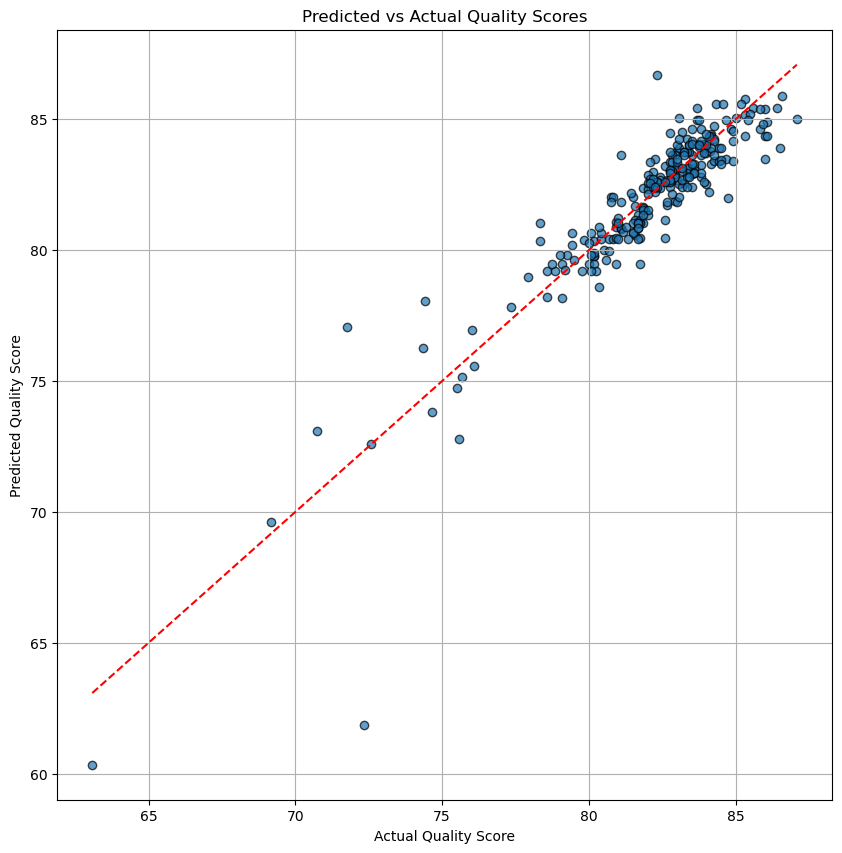

In [45]:
#predicted vs Actual scores
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Quality Scores")
plt.xlabel("Actual Quality Score")
plt.ylabel("Predicted Quality Score")
plt.grid(True)
plt.show()

In [47]:
#Relative Accuracy
relative_accuracy = (1 - mae / np.mean(y_test)) * 100
print(f"Approx. Accuracy   : {relative_accuracy:.2f}%")

Approx. Accuracy   : 99.08%
